## QA over unstructured data

Using Match LSTM, Pointer Networks, as mentioned in paper https://arxiv.org/pdf/1608.07905.pdf

We start with the pre-processing provided by https://github.com/MurtyShikhar/Question-Answering to clean up the data and make neat para, ques files.


### @TODOs:

1. [done] _Figure out how to put in real, pre-trained embeddings in embeddings layer._
2. [done] _Explicitly provide batch size when instantiating model_
3. [done] is ./val.ids.* validation set or test set?: **validation**
4. [done:em] emInstead of test loss, calculate test acc metrics
    1. todo: new metrics like P, R, F1
5. [done] Update unit test codes

In [27]:
from __future__ import unicode_literals, print_function, division
import matplotlib.pyplot as plt
from io import open
import numpy as np
import unicodedata
import traceback
import pickle
import string
import random
import pylab
import time
import re
import os


import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

# from networks import Encoder, MatchLSTMEncoder, PointerDecoder

device = torch.device("cuda")

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

#### Debug Legend

- 5: Print everything that goes in every tensor.
- 4: ??
- 3: Check every model individually
- 2: Print things in training loops
- 1: ??

In [2]:
# Macros 
DATA_LOC = './data/domain/'
MODEL_LOC = './models/mlstms/domain/'
DEBUG = 1

# nn Macros
QUES_LEN, PARA_LEN =  30, 200
VOCAB_SIZE = 120000
# VOCAB_SIZE = glove_file.shape[1]               # @TODO: get actual size
HIDDEN_DIM = 150
EMBEDDING_DIM = 300
BATCH_SIZE = 50                  # Might have total 100 batches.
EPOCHS = 300
TEST_EVERY_ = 1
LR = 0.001
CROP = None

### Encoder 
Use a simple lstm class to have encoder for question and paragraph. 
The output of these will be used in the match lstm

$H^p = LSTM(P)$ 


$H^q = LSTM(Q)$

In [3]:
class Encoder(nn.Module):
    
    def __init__(self, inputlen, macros, glove_file, device):
        super(Encoder, self).__init__()
        
        # Catch dim
        self.inputlen = inputlen
        self.hiddendim = macros['hidden_dim']
        self.embeddingdim =  macros['embedding_dim']
        self.vocablen = macros['vocab_size']
#         self.device = macros['device']
        self.batch_size = macros['batch_size']
        self.debug = macros['debug']
        
        # Embedding Layer
#         self.embedding = nn.Embedding(self.vocablen, self.embeddingdim)
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(glove_file))
        self.embedding.weight.requires_grad = True
       
        # LSTM Layer
        self.lstm = nn.LSTM(self.embeddingdim, self.hiddendim, bidirectional=True, batch_first=False)
        
    def init_hidden(self, batch_size, device):
        
        # Returns a new hidden layer var for LSTM
        return (torch.zeros((2, batch_size, self.hiddendim), device=device), 
                torch.zeros((2, batch_size, self.hiddendim), device=device))
    
    def forward(self, x, h, device):
        
        # Input: x (batch, len ) (current input)
        # Hidden: h (1, batch, hiddendim) (last hidden state)
        
        # Batchsize: b int (inferred)
        b = x.shape[0]
        
        if self.debug > 4: print("x:\t", x.shape)
        if self.debug > 4: print("h:\t", h[0].shape, h[1].shape)
        
        x_emb = self.embedding(x)
        if self.debug > 4: 
            print("x_emb:\t", x_emb.shape)
#             print("x_emb_wrong:\t", x_emb.transpose(1,0).shape)           
            
        ycap, h = self.lstm(x_emb.transpose(1,0), h)
        if self.debug > 4: 
            print("ycap:\t", ycap.shape)
        
        return ycap, h
    
    
# # with torch.no_grad():
# #     print ("Trying out question encoder LSTM")
# #     model = Encoder(QUES_LEN, HIDDEN_DIM, EMBEDDING_DIM, VOCAB_SIZE)
# #     dummy_x = torch.tensor([22,45,12], dtype=torch.long)
# #     hidden = model.init_hidden()
# #     ycap, h = model(dummy_x, hidden)
    
# #     print(ycap.shape)
# #     print(h[0].shape, h[1].shape)


if DEBUG > 4:
    with torch.no_grad():
        
        macros = {
        "ques_len": QUES_LEN,
        "hidden_dim": HIDDEN_DIM, 
        "vocab_size": VOCAB_SIZE, 
        "batch_size": BATCH_SIZE,
        "para_len": PARA_LEN,
        "embedding_dim": EMBEDDING_DIM,
        "lr": LR,
        "debug":5,
        "device":device
    }

        dummy_para = torch.randint(0,VOCAB_SIZE-1,(PARA_LEN*BATCH_SIZE,), device=device).view(BATCH_SIZE,PARA_LEN).long()
    #     print (dummy_para.shape)
        dummy_question = torch.randint(0,VOCAB_SIZE-1,(QUES_LEN*BATCH_SIZE,), device=device).view(BATCH_SIZE,QUES_LEN).long()
    #     print (dummy_question.shape)
        glove_file = torch.randn((VOCAB_SIZE, EMBEDDING_DIM))

    #     print("LSTM with batches")
        ques_model = Encoder(QUES_LEN, macros, glove_file, device).cuda(device)
        para_model = Encoder(QUES_LEN, macros, glove_file, device).cuda(device)
        ques_hidden = ques_model.init_hidden(BATCH_SIZE, device)
        para_hidden = para_model.init_hidden(BATCH_SIZE, device)
        ques_embedded,hidden_ques = ques_model(dummy_question,ques_hidden, device)
        para_embedded,hidden_para = para_model(dummy_para,para_hidden, device)
        
#         print (ques_embedded.shape) # question_length,batch,embedding_dim
#         print (para_embedded.shape) # para_length,batch,embedding_dim
#         print (hidden_para[0].shape,hidden_para[1].shape)

### Match LSTM

Use a match LSTM to compute a **summarized sequential vector** for the paragraph w.r.t the question.

Consider the summarized vector ($H^r$) as the output of a new decoder, where the inputs are $H^p, H^q$ computed above. 

1. Attend the para word $i$ with the entire question ($H^q$)
  
    1. $\vec{G}_i = tanh(W^qH^q + repeat(W^ph^p_i + W^r\vec{h^r_{i-1} + b^p}))$
    
    2. *Computing it*: Here, $\vec{G}_i$ is equivalent to `energy`, computed differently.
    
    3. Use a linear layer to compute the content within the $repeat$ fn.
    
    4. Add with another linear (without bias) with $H_q$
    
    5. $tanh$ the bloody thing
  
  
2. Softmax over it to get $\alpha$ weights.

    1. $\vec{\alpha_i} = softmax(w^t\vec{G}_i + repeat(b))$
    
3. Use the attention weight vector $\vec{\alpha_i}$ to obtain a weighted version of the question and concat it with the current token of the passage to form a vector $\vec{z_i}$

4. Use $\vec{z_i}$ to compute the desired $h^r_i$:

    1. $ h^r_i = LSTM(\vec{z_i}, h^r_{i-1}) $
    


In [4]:
class MatchLSTMEncoder(nn.Module):
    
    def __init__(self, macros, device):
        
        super(MatchLSTMEncoder, self).__init__()
        
        self.hidden_dim = macros['hidden_dim']
        self.ques_len = macros['ques_len']
        self.batch_size = macros['batch_size']
        self.debug = macros['debug']    
        
        # Catch lens and params
        self.lin_g_repeat_a_dense = nn.Linear(2*self.hidden_dim, self.hidden_dim)
        self.lin_g_repeat_b_dense = nn.Linear(self.hidden_dim, self.hidden_dim, bias=False)
        self.lin_g_nobias = nn.Linear(2*self.hidden_dim, self.hidden_dim, bias=False)
        
        self.alpha_i_w = nn.Parameter(torch.rand((self.hidden_dim, 1)))
        self.alpha_i_b = nn.Parameter(torch.rand((1)))
        
        self.lstm_summary = nn.LSTM((self.ques_len+1)*2*self.hidden_dim, self.hidden_dim, batch_first=False)
                                      
    
    def forward(self, H_p, h_ri, H_q, hidden, device):
        """
            Ideally, we would have manually unrolled the lstm 
            but due to memory constraints, we do it in the module.
        """
        
        # Find the batchsize
        batch_size = H_p.shape[1]
        
        H_r = torch.empty((0, batch_size, self.hidden_dim), device=device, dtype=torch.float)
        H_r = torch.cat((H_r, h_ri), dim=0)
        
        if self.debug > 4:
            print( "H_p:\t\t\t", H_p.shape)
            print( "H_q:\t\t\t", H_q.shape)
            print( "h_ri:\t\t\t", h_ri.shape)
            print( "H_r:\t\t\t", H_r.shape)
            print( "hid:\t\t\t", hidden.shape)
        
        for i in range(H_p.shape[0]):
            
            # We call the (W^P.H^P + W^rh^r_i-1 + b^P) as lin_repeat_input.
            
            # We first write out its two components as
            lin_repeat_input_a = self.lin_g_repeat_a_dense(H_p[i].view(1, batch_size, -1))
            if self.debug > 4: print("lin_repeat_input_a:\t", lin_repeat_input_a.shape)
            
            lin_repeat_input_b = self.lin_g_repeat_b_dense(H_r[i].view(1, batch_size, -1))
            if self.debug > 4: print("lin_repeat_input_b:\t", lin_repeat_input_b.shape)
            
            # Add the two terms up
            lin_repeat_input_a.add_(lin_repeat_input_b)
#             if self.debug > 4: print("lin_g_input_b unrepeated:", lin_g_input_b.shape)

            lin_g_input_b = lin_repeat_input_a.repeat(H_q.shape[0], 1, 1)
            if self.debug > 4: print("lin_g_input_b:\t\t", lin_g_input_b.shape)

            # lin_g_input_a = self.lin_g_nobias.matmul(H_q.view(-1, self.ques_len, self.hidden_dim)) #self.lin_g_nobias(H_q)
            lin_g_input_a =  self.lin_g_nobias(H_q)
            if self.debug > 4: print("lin_g_input_a:\t\t", lin_g_input_a.shape)

            G_i = F.tanh(lin_g_input_a + lin_g_input_b)
            if self.debug > 4: print("G_i:\t\t\t", G_i.shape)
            # Note; G_i should be a 1D vector over ques_len
            
            # Attention weights
            alpha_i_input_a = G_i.transpose(1,0).matmul(self.alpha_i_w).view(batch_size, 1, -1)
            if self.debug > 4: print("alpha_i_input_a:\t", alpha_i_input_a.shape)

            alpha_i_input = alpha_i_input_a.add_(self.alpha_i_b.view(-1,1,1).repeat(1,1,self.ques_len))
            if self.debug > 4: print("alpha_i_input:\t\t", alpha_i_input.shape)

            # Softmax over alpha inputs
            alpha_i = F.softmax(alpha_i_input, dim=-1)
            if self.debug > 4: print("alpha_i:\t\t", alpha_i.shape)  
                
            # Weighted summary of question with alpha    
            z_i_input_b = (
                            H_q.transpose(1, 0) *
                           (alpha_i.view(batch_size, self.ques_len, -1).repeat(1, 1, 2*self.hidden_dim))
                          ).transpose(1, 0)
            if self.debug > 4: print("z_i_input_b:\t\t", z_i_input_b.shape)

            z_i = torch.cat((H_p[i].view(1, batch_size, -1), z_i_input_b), dim=0)
            if self.debug > 4: print("z_i:\t\t\t", z_i.shape)

            # Take input from LSTM, concat in H_r and nullify the temp var.                
            h_ri, (_, hidden) = self.lstm_summary(z_i.transpose(1,0).contiguous().view(1, batch_size, -1), 
                                             (H_r[i].view(1,batch_size, -1), hidden))
            if self.debug > 4:
                print("newh_ri:\t\t", h_ri.shape)
                print("newhidden:\t\t", hidden.shape)
            H_r = torch.cat((H_r, h_ri), dim=0)
            
            if self.debug > 4:
                print("\tH_r:\t\t\t", H_r.shape)

        return H_r[1:]
    
    def init_hidden(self, batch_size, device):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return torch.zeros((1, batch_size, self.hidden_dim), device=device)
#                 torch.zeros((1, batch_size, self.hidden_dim), device=device))



if DEBUG > 4:
    with torch.no_grad():
        
        macros = {
            "ques_len": QUES_LEN,
            "hidden_dim": HIDDEN_DIM, 
            "vocab_size": VOCAB_SIZE, 
            "batch_size": BATCH_SIZE,
            "para_len": PARA_LEN,
            "embedding_dim": EMBEDDING_DIM,
            "lr": LR,
            "debug":5,
            "device":device
        }
            
        matchLSTMEncoder = MatchLSTMEncoder(macros,device).cuda(device)
        hidden = matchLSTMEncoder.init_hidden(BATCH_SIZE,device)
        para_embedded = torch.rand((PARA_LEN, BATCH_SIZE, 2*HIDDEN_DIM), device=device)
        ques_embedded = torch.rand((QUES_LEN, BATCH_SIZE, 2*HIDDEN_DIM), device=device)
        h_ri = torch.randn(1, BATCH_SIZE, HIDDEN_DIM, device=device)
    #     if DEBUG:
    #         print ("init h_ri shape is: ", h_ri.shape)
    #         print ("the para length is ", len(para_embedded))
        H_r = matchLSTMEncoder(para_embedded.view(-1,BATCH_SIZE,2*HIDDEN_DIM),
                               h_ri, 
                               ques_embedded, 
                               hidden,
                               device)
        print("H_r: ", H_r.shape)
        
        
        

### Pointer Network

Using a ptrnet over $H_r$ to unfold and get most probable spans.
We use the **boundry model** to do that (predict start and end of seq).

A simple energy -> softmax -> decoder. Where softmaxed energy is supervised.

In [5]:
class PointerDecoder(nn.Module):
    
    def __init__(self, macros, device):
        super(PointerDecoder, self).__init__()
        
        # Keep args
        self.hidden_dim = macros['hidden_dim']
        self.batch_size = macros['batch_size']
        self.para_len = macros['para_len']
        self.debug = macros['debug']
        
        self.lin_f_repeat = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.lin_f_nobias = nn.Linear(self.hidden_dim, self.hidden_dim, bias=False)
        
        self.beta_k_w = nn.Parameter(torch.randn(self.hidden_dim, 1))
        self.beta_k_b = nn.Parameter(torch.randn(1))
        
        self.lstm = nn.LSTM(self.hidden_dim*self.para_len, self.hidden_dim, batch_first=False)

    
    def init_hidden(self, batch_size, device):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return torch.zeros((1, batch_size, self.hidden_dim), device=device)
#                 torch.zeros((1, batch_size, self.hidden_dim), device=device))
    
    def forward(self, h_ak, H_r, hidden, device):
        
        # h_ak (current decoder's last op) (1,batch,hiddendim)
        # H_r (weighted summary of para) (P, batch, hiddendim)
        batch_size = H_r.shape[1]
        
        if self.debug > 4:
            print("h_ak:\t\t\t", h_ak.shape)
            print("H_r:\t\t\t", H_r.shape)
            print("hidden:\t\t\t", hidden.shape)
            
        # Prepare inputs for the tanh used to compute energy
        f_input_b = self.lin_f_repeat(h_ak)
        if self.debug > 4: print("f_input_b unrepeated:  ", f_input_b.shape)
        
        #H_r shape is ([PARA_LEN, BATCHSIZE, EmbeddingDIM])
        f_input_b = f_input_b.repeat(H_r.shape[0], 1, 1)
        if self.debug > 4: print("f_input_b repeated:\t", f_input_b.shape)
            
        f_input_a = self.lin_f_nobias(H_r)
        if self.debug > 4: print("f_input_a:\t\t", f_input_a.shape)
            
        # Send it off to tanh now
        F_k = F.tanh(f_input_a+f_input_b)
        if self.debug > 4: print("F_k:\t\t\t", F_k.shape) #PARA_LEN,BATCHSIZE,EmbeddingDim
        
        # Attention weights
        beta_k_input_a = F_k.transpose(1,0).matmul(self.beta_k_w).view(batch_size, 1, -1)
        if self.debug > 4: print("beta_k_input_a:\t\t", beta_k_input_a.shape)
            
        beta_k_input = beta_k_input_a.add_(self.beta_k_b.repeat(1,1,self.para_len))
        if self.debug > 4: print("beta_k_input:\t\t", beta_k_input.shape)
            
        beta_k = F.softmax(beta_k_input, dim=-1)
        if self.debug > 4: print("beta_k:\t\t\t", beta_k.shape)
        
        lstm_input_a = H_r.transpose(1,0) * (beta_k.view(batch_size, self.para_len, -1).repeat(1,1,self.hidden_dim))
        if self.debug > 4: print("lstm_input_a:\t\t", lstm_input_a.shape)
        
        h_ak, (_, hidden) = self.lstm(lstm_input_a.transpose(1,0).contiguous().view(1, batch_size, -1), (h_ak, hidden))
        
        return h_ak, hidden, F.log_softmax(beta_k_input, dim=-1)
            
if DEBUG > 4:
    with torch.no_grad():
        macros = {
            "ques_len": QUES_LEN,
            "hidden_dim": HIDDEN_DIM, 
            "vocab_size": VOCAB_SIZE, 
            "batch_size": BATCH_SIZE,
            "para_len": PARA_LEN,
            "embedding_dim": EMBEDDING_DIM,
            "lr": LR,
            "debug":5,
            "device":device
        }
        
        pointerDecoder = PointerDecoder(macros, device).cuda(device)
        h_ak = torch.randn(1,BATCH_SIZE,HIDDEN_DIM, device=device)
        H_r = torch.randn(PARA_LEN, BATCH_SIZE, HIDDEN_DIM, device=device)
        hidden = pointerDecoder.init_hidden(BATCH_SIZE, device)
        h_ak, hidden, beta_k = pointerDecoder(h_ak, H_r, hidden, device)
        print (beta_k.shape)

# Pull the real data from disk.

Files stored in `./data/squad/train.ids.*`
Pull both train and test.

In [6]:
def prepare_data(data_loc, macros, crop=None):
    """
        Given the dataloc and the data available in a specific format, it would pick the data up, and make trainable matrices,
        Harvest train_P, train_Q, train_Y, test_P, test_Q, test_Y matrices in this format
        
        If crop given, will trim the data at a certain length
        
        **return_type**: np matrices
    """
    
    # Unpacking macros
    PARA_LEN = macros['para_len']
    QUES_LEN = macros['ques_len']
    
    train_q = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'train.ids.question')))])
    train_p = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'train.ids.context')))])
    train_y = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'train.span')))])

    test_q = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'val.ids.question')))])
    test_p = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'val.ids.context')))])
    test_y = np.asarray([[int(x) for x in datum.split()] for datum in list(open(os.path.join(data_loc, 'val.span')))])

    if macros['debug'] > 3:
        print("Train Q: ", train_q.shape)
        print("Train P: ", train_p.shape)
        print("Train Y: ", train_y.shape)
        print("Test Q: ", test_q.shape)
        print("Test P: ", test_p.shape)
        print("Test Y: ", test_y.shape)
    
    """
        Parse the semi-raw data:
            - shuffle
            - pad, prepare
            - dump useless vars
    """
    # Shuffle data
    
    if crop:
        index_train, index_test = np.random.choice(np.arange(len(train_p)), crop), \
                                  np.random.choice(np.arange(len(test_p)), crop)
    else:
        index_train, index_test = np.arange(len(train_p)), np.arange(len(test_p))
        np.random.shuffle(index_train)
        np.random.shuffle(index_test)

    train_p, train_q, train_y = train_p[index_train], train_q[index_train], train_y[index_train]
    test_p, test_q, test_y = test_p[index_test], test_q[index_test], test_y[index_test]

#     sanity_check(train_p, train_y)

    if macros['debug'] >= 5:
        print("Max q len: ", max(len(q) for q in train_q))
        
    
    # Pad and prepare
    train_P = np.zeros((len(train_p), PARA_LEN))
    train_Q = np.zeros((len(train_q), QUES_LEN))
    train_Y_start = np.zeros((len(train_p), PARA_LEN))
    train_Y_end = np.zeros((len(train_p), PARA_LEN))

    test_P = np.zeros((len(test_p), PARA_LEN))
    test_Q = np.zeros((len(test_q), QUES_LEN))
    test_Y_start = np.zeros((len(test_p), PARA_LEN))
    test_Y_end = np.zeros((len(test_p), PARA_LEN))
    
#     print(train_P.shape)

    crop_train = []    # Remove these rows from training
    for i in range(len(train_p)):
        p = train_p[i]
        q = train_q[i]
        y = train_y[i]
        
        # First see if you can keep this example or not (due to size)
        if y[0] >= PARA_LEN or y[1] >= PARA_LEN:
            crop_train.append(i)
            continue


        train_P[i, :min(PARA_LEN, len(p))] = p[:min(PARA_LEN, len(p))]
        train_Q[i, :min(QUES_LEN, len(q))] = q[:min(QUES_LEN, len(q))]
        train_Y_start[i, y[0]] = 1
        train_Y_end[i, y[1]] = 1

    crop_test = []
    for i in range(len(test_p)):
        p = test_p[i]
        q = test_q[i]
        y = test_y[i]

        # First see if you can keep this example or not (due to size)
        if y[0] >= PARA_LEN or y[1] >= PARA_LEN:
            crop_test.append(i)
            continue

        test_P[i, :min(PARA_LEN, len(p))] = p[:min(PARA_LEN, len(p))]
        test_Q[i, :min(QUES_LEN, len(q))] = q[:min(QUES_LEN, len(q))]
        test_Y_start[i, y[0]] = 1
        test_Y_end[i, y[1]] = 1
        
        
    # Remove the instances which are in crop_train
    train_P = np.delete(train_P, crop_train, axis=0)
    train_Q = np.delete(train_Q, crop_train, axis=0)
    train_Y_start = np.delete(train_Y_start, crop_train, axis=0)
    train_Y_end = np.delete(train_Y_end, crop_train, axis=0)
    
    test_P = np.delete(test_P, crop_test, axis=0)
    test_Q = np.delete(test_Q, crop_test, axis=0)
    test_Y_start = np.delete(test_Y_start, crop_test, axis=0)
    test_Y_end = np.delete(test_Y_end, crop_test, axis=0)

    if macros['debug'] >= 1:
        print("Train Q: ", train_Q.shape)
        print("Train P: ", train_P.shape)
        print("Train Y: ", train_Y_start.shape)
        print("Test Q: ", test_Q.shape)
        print("Test P: ", test_P.shape)
        print("Test Y: ", test_Y_start.shape)
        print("Crop_train: ", len(crop_train))
        print("Crop_test: ", len(crop_test))
    # Let's free up some memory now
    train_p, train_q, train_y, test_p, test_q, test_y = None, None, None, None, None, None
    
    # Load embedding matrics
    vectors = np.load(os.path.join(data_loc, 'glove.new.trimmed.300.npy'))
    
    return train_P, train_Q, train_Y_start, train_Y_end, test_P, test_Q, test_Y_start, test_Y_end, vectors

In [7]:
# macros = {
#     "ques_len": QUES_LEN,
#     "hidden_dim": HIDDEN_DIM, 
#     "vocab_size": VOCAB_SIZE, 
#     "batch_size": BATCH_SIZE,
#     "para_len": PARA_LEN,
#     "embedding_dim": EMBEDDING_DIM,
#     "debug": 5
# } 

# a = prepare_data(DATA_LOC, macros=macros, crop=None)

# Training, and running the model
- Write a train fn
- Write a training loop invoking it
- Fill in real data

----------

Feats:
- Function to test every n epochs.
- Report train accuracy every epoch
- Store the train, test accuracy for every instance.


In [8]:
# Function to save the model
def save_model(loc, models, epochs=0, optimizer=None):
    """
        Input:
            loc: str of the folder where the models are to be saved
            models: dict of 'model_name': model_object
            epochs, optimizers are int, torch.optims (discarded right now).
    """
    
    assert type(models) is dict and len(models.keys()) == 4
    
    # Assumes four models. Doesn't save device/epochs/optimizer right now.
    
    for name in models:
        torch.save(models[name], os.path.join(loc, name+'.torch'))
    

In [9]:
def train(para_batch,
          ques_batch,
          answer_start_batch,
          answer_end_batch,
          ques_model,
          para_model,
          mlstm_model,
          pointer_decoder_model,
          optimizer, 
          loss_fn,
          macros,
          debug=2):

    """
    
    :param para_batch: paragraphs (batch, max_seq_len_para) 
    :param ques_batch: questions corresponding to para (batch, max_seq_len_ques)
    :param answer_start_batch: one-hot vector denoting pos of span start (batch, max_seq_len_para)
    :param answer_end_batch: one-hot vector denoting pos of span end (batch, max_seq_len_para)
    
    # Models
    :param ques_model: model to encode ques
    :param para_model: model to encode para
    :param mlstm_model: model to match para, ques to get para summary
    :param pointer_decoder_model: model to get a pointer over start and end span pointer
    
    # Loss and Optimizer.
    :param loss_fn: 
    :param optimizer: 
    
    :return: 
    
    
    NOTE: When using MSE, 
        - target labels are one-hot
        - target label is float tensor
        - shape (batch, 1, len)
        
        When using CrossEntropy
        - target is not onehot
        - long
        - shape (batch, )
    """
    try:    
    #     DEBUG = debug
    #     BATCH_SIZE = macros['batch_size']
    #     HIDDEN_DIM = macros['hidden_dim']

        if debug >=2: 
            print("\tpara_batch:\t\t", para_batch.shape)
            print("\tques_batch:\t\t", ques_batch.shape)
            print("\tanswer_start_batch:\t", answer_start_batch.shape)
            print("\tanswer_end_batch:\t\t", answer_end_batch.shape)

        # Wiping all gradients
        optimizer.zero_grad()

        # Initializing all hidden states.
        hidden_quesenc = ques_model.init_hidden(macros['batch_size'], device)
        hidden_paraenc = para_model.init_hidden(macros['batch_size'], device)
        hidden_mlstm = mlstm_model.init_hidden(macros['batch_size'], device)
        hidden_ptrnet = pointer_decoder_model.init_hidden(macros['batch_size'], device)
        h_ri = torch.zeros((1, macros['batch_size'], macros['hidden_dim']), dtype=torch.float, device=device)
        h_ak = torch.zeros((1, macros['batch_size'], macros['hidden_dim']), dtype=torch.float, device=device)
        if debug >= 2: print("------------Instantiated hidden states------------")

        #passing the data through LSTM pre-processing layer
        H_q, ques_model_hidden = ques_model(ques_batch, hidden_quesenc, device=device)
        H_p, para_model_hidden = para_model(para_batch, hidden_paraenc, device=device)
        if debug >= 2: 
            print("\tH_q:\t\t", H_q.shape)
            print("\tH_p:\t\t", H_p.shape)
            print("\tH_ri:\t\t", h_ri.shape)
    #         raw_input("Check memory and ye shall continue")
            print("------------Encoded hidden states------------")

        H_r = mlstm_model(H_p.view(-1, macros['batch_size'], 2*macros['hidden_dim']), h_ri, H_q, hidden_mlstm, device=device)
        if debug >= 2: print("------------Passed through matchlstm------------")

        #Passing the paragraph embddin via pointer network to generate final answer pointer.
        h_ak, hidden_ptrnet, beta_k_start = pointer_decoder_model(h_ak, H_r, hidden_ptrnet, device=device)
        h_ak, hidden_ptrnet, beta_k_end = pointer_decoder_model(h_ak, H_r, hidden_ptrnet, device=device)
        if debug >= 2: print("------------Passed through pointernet------------")


        # For crossentropy
        _, answer_start_batch = answer_start_batch.max(dim=2)
        _, answer_end_batch = answer_end_batch.max(dim=2)
        answer_start_batch = answer_start_batch.view(-1).long()
        answer_end_batch = answer_end_batch.view(-1).long()
#         print(beta_k_start.view(-1, macros['para_len']).shape, answer_start_batch.view(-1).shape)
        
        # Calculate Loss
        loss = loss_fn(beta_k_start.view(-1, macros['para_len']), answer_start_batch)
        loss += loss_fn(beta_k_end.view(-1, macros['para_len']), answer_end_batch)
#         loss = loss_fn(beta_k_start, answer_start_batch)
#         loss += loss_fn(beta_k_end, answer_end_batch)
        if debug >= 2: print("------------Calculated loss------------")

        loss.backward()
        if debug >= 2: print("------------Calculated Gradients------------")

        #optimization step
        optimizer.step()
        if debug >= 2: print("------------Updated weights.------------")
            
        return beta_k_start, beta_k_end, loss
    
    except: 
        traceback.print_exc()

In [10]:
# Predict function (no grad, no eval)
def predict(para_batch,
            ques_batch,
            ques_model,
            para_model,
            mlstm_model,
            pointer_decoder_model,
            macros,
            loss_fn=None,
            debug=DEBUG):
    """
        Function which returns the model's output based on a given set of P&Q's. 
        Does not convert to strings, gives the direct model output.
        
        Expects:
            four models
            data
            misc macros
    """
    
#     BATCH_SIZE = macros['batch_size']
    BATCH_SIZE = ques_batch.shape[0]
    HIDDEN_DIM = macros['hidden_dim']
    DEBUG = debug
    
    if debug >=2: 
        print("\tpara_batch:\t\t", para_batch.shape)
        print("\tques_batch:\t\t", ques_batch.shape)
        
    with torch.no_grad():    

        # Initializing all hidden states.
        hidden_quesenc = ques_model.init_hidden(BATCH_SIZE, device)
        hidden_paraenc = para_model.init_hidden(BATCH_SIZE, device)
        hidden_mlstm = mlstm_model.init_hidden(BATCH_SIZE, device)
        hidden_ptrnet = pointer_decoder_model.init_hidden(BATCH_SIZE, device)
        h_ri = torch.zeros((1, BATCH_SIZE, HIDDEN_DIM), dtype=torch.float, device=device)
        h_ak = torch.zeros((1, BATCH_SIZE, HIDDEN_DIM), dtype=torch.float, device=device)
        if DEBUG >= 2: print("------------Instantiated hidden states------------")
            
        #passing the data through LSTM pre-processing layer
        H_q, ques_model_hidden = ques_model(ques_batch, hidden_quesenc, device)
        H_p, para_model_hidden = para_model(para_batch, hidden_paraenc, device)
        if DEBUG >= 2: 
            print("\tH_q:\t\t", H_q.shape)
            print("\tH_p:\t\t", H_p.shape)
            print("\tH_ri:\t\t", h_ri.shape)
#             raw_input("Check memory and ye shall continue")
            print("------------Encoded hidden states------------")

        H_r = mlstm_model(H_p.view(-1, BATCH_SIZE, 2*HIDDEN_DIM), h_ri, H_q, hidden_mlstm, device)
        if DEBUG >= 2: print("------------Passed through matchlstm------------")

        #Passing the paragraph embddin via pointer network to generate final answer pointer.
        h_ak, hidden_ptrnet, beta_k_start = pointer_decoder_model(h_ak, H_r, hidden_ptrnet, device)
        _, _, beta_k_end = pointer_decoder_model(h_ak, H_r, hidden_ptrnet, device)
        if DEBUG >= 2: print("------------Passed through pointernet------------")
                            
        # For crossentropy
#         _, answer_start_batch = answer_start_batch.max(dim=2)[1]
#         _, answer_end_batch = answer_end_batch.max(dim=2)[1]
#         print("labels: ", answer_start_batch.shape)[1]
            
#         #How will we manage batches for loss.
#         loss = loss_fn(beta_k_start, answer_start_batch)
#         loss += loss_fn(beta_k_end, answer_end_batch)
#         if debug >= 2: print("------------Calculated loss------------")
            
        return (beta_k_start, beta_k_end, 0.0)


In [11]:
# Eval function (no grad no eval no nothing)
def eval(y_cap, y, metrics={'em':None, 'p':None, 'r':None, 'f1':None}):
    """ 
        Returns the exact-match (em) metric by default.
        Can specifiy more in a list (TODO)
        
        Inputs:
        - y_cap: list of two tensors (start, end) of dim [BATCH_SIZE, PARA_LEN] each
        - y: list of two tensors (start, end) of dim [BATCH_SIZE, 1] each
    """
    
#     y_cap= torch.argmax(y_cap[0], dim=1).float(), torch.argmax(y_cap[1], dim=1).float()
#     y = torch.argmax(y[0], dim=1).float(), torch.argmax(y[1], dim=1).float()
    
    
    # If we want f1 and haven't specified that we want p and q, fuck it and add it there
    if 'f1' in metrics.keys():
        metrics['p'] = None 
        metrics['r'] = None
    
    # Convert to numpy arrays of size (batch, 2)
    y_cap= np.vstack((torch.argmax(y_cap[0], dim=1).float().data, torch.argmax(y_cap[1], dim=1).float().data)).transpose()
    y = np.vstack((torch.argmax(y[0], dim=1).float().data, torch.argmax(y[1], dim=1).float().data)).transpose()
      
    # First, if start > end, fix that (we're cool that way.)
    for i in range(y_cap.shape[0]):
        if y_cap[i][0] > y_cap[i][1]: 
            y_cap[i] = y_cap[i][[1,0]]
            
    if "em" in metrics.keys():
        metrics['em'] = np.mean(np.logical_and(np.equal(y[:,0], y_cap[:,0]),np.equal(y[:,1], y_cap[:,1])))
            
    if 'f1' in metrics.keys():
        
        f1, pr, rk = [], [], []
        for i in range(y.shape[0]):
#             _y, _y_cap = [], []
            
            if y[i][0] == y[i][1]:
                _y = [int(y[i][0])]
            else:
                _y = range(y[i][0], y[i][1])
                
            if y_cap[i][0] == y_cap[i][1]:
                _y_cap = [int(y_cap[i][0])]
            else:
                _y_cap = range(y_cap[i][0], y_cap[i][1])
                
#             print(_y)
#             print(_y_cap)
                
            intersection = len(set(_y).intersection(_y_cap))
            
            positives = float(len(_y_cap))
            truth = float(len(_y))
            
            p = intersection/positives
            r = intersection/truth
            
#             try:
#                 p = intersection/positives
#                 r = intersection/truth
#             except:
#                 traceback.print_exc()
#                 print("y: ", y[i])
#                 print("ycap: ", y_cap[i])
#                 print("pos: ", positives)
            
            f = (2*p*r)/(p+r) if p > 0 and r > 0 else 0.0
            
            f1.append(f)
            pr.append(p)
            rk.append(r)
            
        f1 = np.mean(f1)
        pr = np.mean(pr)
        rk = np.mean(rk)
        
        metrics['f1'] = f1
        metrics['p'] = pr
        metrics['r'] = rk
            
                
            
            
                
#         _y_cap = np.asarray([np.arange(x[0],x[1]) for x in y_cap])
#         _y = np.asarray([np.arange(x[0],x[1]) for x in y])
        
# #         intersection = [float(len(np.intersect1d(y[i],y_cap[i]))) for i in range(len(y))]
#         intersection = np.min((y[:,1], y_cap[:,1]), axis=0)-np.max((y[:,0], y_cap[:,0]), axis=0).astype(np.float)
#         intersection[intersection<0] = 0.0
#         patchwork = np.zeros(intersection.shape)
#         for i in range(len(y)):
#             if y[i][0] == y[i][1] and y[i][0]
#         intersection =  intersection.astype(np.float)
        
#         positives = y_cap[:,1] - y_cap[:,0]
#         truth = y[:,1] - y[:,0]
        
#         p = np.mean(intersection/positives.astype(np.float))
#         r = np.mean(intersection/truth.astype(np.float))
        
#         metrics['p'] = p
#         metrics['r'] = r
        
#         # f1
#         # If p or r is zero, f1 is zero
#         if p > 0 and r > 0:
#             metrics['f1'] = 2*p*r/(p+r)
#         else:
#             metrics['f1'] = 0.0
    
#     else:
#         if 'p' in metrics.keys():
            
#             intersection = np.min((y[:,1], y_cap[:,1]), axis=0)-np.max((y[:,0], y_cap[:,0]), axis=0)
#             intersection[intersection<0] = 0
#             intersection =  intersection.astype(np.float)

#             positives = y_cap[:,1] - y_cap[:,0]

#             p = np.mean(intersection/positives)

#             metrics['p'] = p
            
#         if 'r'  in metrics.keys():

#             intersection = np.min((y[:,1], y_cap[:,1]), axis=0)-np.max((y[:,0], y_cap[:,0]), axis=0)
#             intersection[intersection<0] = 0
#             intersection =  intersection.astype(np.float)

#             truth = y[:,1] - y[:,0]

#             r = np.mean(intersection/truth)

#             metrics['r'] = r
        
#     if metrics['em'] > 0 and metrics['f1'] <= 0:
#         print("Here comes")
#         i = np.argmax(np.logical_and(np.equal(y[:,0], y_cap[:,0]),np.equal(y[:,1], y_cap[:,1])))
#         print(i,'\n',y[i],y_cap[i])
        
    if DEBUG >= 3: 
        print("Test performance: ", metrics)
        print("------------Evaluated------------")
        
    return metrics

if True:
    # Testing this function
    metrics = {'em':None}
#     y = torch.tensor([[3]]).float(), torch.tensor([[4]]).float()
    y = torch.tensor([[0,0,3,0], [0,2,0,0]]), torch.tensor([[0,0,0,3], [0,0,0,3]])
    y_cap = torch.tensor([[0,0,3,0],[0,0,3,0]]), torch.tensor([[0,0,0,3],[0,0,0,3]])
#     y = torch.randint(0, PARA_LEN, (BATCH_SIZE,)).float(), torch.randint(0, PARA_LEN, (BATCH_SIZE,)).float()
#     y_cap = torch.rand((BATCH_SIZE, PARA_LEN)), torch.rand((BATCH_SIZE, PARA_LEN))
    print(eval(y_cap, y))   

{u'em': 0.5, u'p': 1.0, u'r': 0.75, u'f1': 0.8333333333333333}


In [12]:
def training_loop(_models, _data, _macros, _epochs, _save=0, _test_eval=0, _train_eval=0, _debug=2):
    """
        > Instantiate models
        > Instantiate loss, optimizer
        > Instantiate ways to store loss

        > Per epoch
            > sample batch and give to train fn
            > get loss
            > if epoch %k ==0: get test accuracy

        > have fn to calculate test accuracy
        
        > _save: int
            > 0: dont
            > 1+: save every _save epoch (overwrite)
            > -1 -> save best (turned to 1 if test evals dont happen.)
        
        > Save the model at every epoch if we don't test on test. 
            > else save on the best performning mode
    """
    
    # Unpack data
    DEBUG = _debug
    train_P = _data['train']['P']
    train_Q = _data['train']['Q']
    train_Y_start = _data['train']['Ys']
    train_Y_end = _data['train']['Ye']
    test_P = _data['test']['P']
    test_Q = _data['test']['Q']
    test_Y_start = _data['test']['Ys']
    test_Y_end = _data['test']['Ye']

    ques_model, para_model, mlstm_model, pointer_decoder_model = _models
    _data = None

    # Instantiate Loss
#         loss_fn = nn.MSELoss()
    loss_fn = nn.NLLLoss()
    optimizer = optim.Adam(list(filter(lambda p: p.requires_grad, ques_model.parameters())) + 
                             list(filter(lambda p: p.requires_grad, para_model.parameters())) + 
                             list(mlstm_model.parameters()) + 
                             list(pointer_decoder_model.parameters()), lr=macros['lr'])
#         optimizer = optim.Adam(list(ques_model.parameters()) + \
#                                list(para_model.parameters()) + \
#                                list(mlstm_model.parameters()) + \
#                               list(pointer_decoder_model.parameters()), lr=macros['lr'])

    # Losses
    train_losses = []
    train_em = []
    train_f = []
    test_losses = []
    test_em = []
    test_f = []
    best_test = 0.0
    found_best_test = False
    
    try: 

        # Training Loop
        for epoch in range(_epochs):
            print("Epoch: ", epoch, "/", _epochs)

            epoch_loss = []
            epoch_train_em = []
            epoch_train_f = []
            epoch_time = time.time()

            for iter in range(int(len(train_P)/BATCH_SIZE)):
    #         for iter in range(2):

                batch_time = time.time()

                # Sample batch and train on it
                sample_index = np.random.randint(0, len(train_P), _macros['batch_size'])
            
#                 grad_old = sum([x.grad.sum().item() for x in params])

                y_cap_start, y_cap_end, loss = train(
                    para_batch = torch.tensor(train_P[sample_index], dtype=torch.long, device=device),
                    ques_batch = torch.tensor(train_Q[sample_index], dtype=torch.long, device=device),
                    answer_start_batch = torch.tensor(train_Y_start[sample_index], dtype=torch.float, device=device).view( _macros['batch_size'], 1, _macros['para_len']),
                    answer_end_batch = torch.tensor(train_Y_end[sample_index], dtype=torch.float, device=device).view(_macros['batch_size'], 1, _macros['para_len']),
                    ques_model = ques_model,
                    para_model = para_model,
                    mlstm_model = mlstm_model,
                    pointer_decoder_model = pointer_decoder_model,
                    optimizer = optimizer, 
                    loss_fn= loss_fn,
                    macros=_macros,
                    debug=_macros['debug']
                )

                if _train_eval: 

                    # Calculate train accuracy for this minibatch
                    metrics = eval(
                        y=(torch.tensor(train_Y_start[sample_index], dtype=torch.long, device=device).view( -1, _macros['para_len']),
                            torch.tensor(train_Y_end[sample_index], dtype=torch.long, device=device).view(-1, _macros['para_len'])),
                        y_cap=[y_cap_start.squeeze(), y_cap_end.squeeze()])

                    epoch_train_em.append(metrics['em'])
                    epoch_train_f.append(metrics['f1'])
    
                epoch_loss.append(loss.item())
    
#                 grad_new = sum([x.grad.sum().item() for x in params])

                print("Batch:\t%d" % iter,"/%d\t\b: " % (len(train_P)/_macros['batch_size']),
                      str("%s" % (time.time() - batch_time))[:8], 
                      str("\t\b%s" % (time.time() - epoch_time))[:10], 
                      "\tl:%f" % loss.item(),
                      "\tem:%f" % epoch_train_em[-1] if _train_eval else "",
                     "\t\bf1:%f" % epoch_train_f[-1] if _train_eval else "")
#                      "\t\b\b%s" % grad_new - grad_old)
#                      end=None if iter+1 == int(len(train_P)/BATCH_SIZE) else "\r")

            train_losses.append(epoch_loss)
        
            if _train_eval: 
                train_em.append(epoch_train_em)
                train_f.append(epoch_train_f)
#             if np.mean(epoch_train_em) > best_test_em:
#                 found_best_test_em = True
#                 best_test_em = np.mean(epoch_train_em)
                
            if _test_eval and epoch % _test_eval == 0:

                y_cap_start, y_cap_end, test_loss = predict(
                    para_batch = torch.tensor(test_P, dtype=torch.long, device=device),
                    ques_batch = torch.tensor(test_Q, dtype=torch.long, device=device),
                    ques_model = ques_model,
                    para_model = para_model,
                    mlstm_model = mlstm_model,
                    pointer_decoder_model = pointer_decoder_model,
                    macros = _macros,
                    loss_fn= loss_fn,
                    debug = _macros['debug']
                )
                metrics = eval(
                    y=(torch.tensor(test_Y_start, dtype=torch.long, device=device).view( -1, _macros['para_len']),
                        torch.tensor(test_Y_end, dtype=torch.long, device=device).view(-1, _macros['para_len'])),
                    y_cap=[y_cap_start.squeeze(), y_cap_end.squeeze()])

                test_losses.append(test_loss)
                test_em.append(metrics['em'])
                test_f.append(metrics['f1'])
                
                # Check if we outperformed the best one.
                if metrics['f1'] > best_test:
                    
                    # Set flag
                    found_best_test = True
                    
                    # Update value
                    best_test = metrics['f1']   
                
            # Saving logic
            if _save == 0:
                pass
            elif ( _save>0 and epoch % _save == 0) or \
            ( _save == -1 and found_best_test ):
                models = { 'ques_model': ques_model,
                           'para_model': para_model,
                           'mlstm_model':  mlstm_model,
                           'pointer_decoder_model': pointer_decoder_model
                         }
                
                save_model(macros['save_model_loc'], models,
                          epochs=epoch,
                           optimizer=optimizer)
                
                print("Saving new model on epoch %d" % epoch)
            
            # Reset flags
            found_best_test = False
            
            # At the end of every epoch, do print the average epoch loss, and other stat
            print("\nEpoch performance: ",
                  "%ssec" % str(time.time() - epoch_time)[:6],
                  "Trl:%f" % np.mean(epoch_loss, axis=0),
                  "\n\tTrem:%f" % np.mean(epoch_train_em) if _train_eval and epoch % _train_eval == 0 else "",
                  "\tTrf1:%f" % np.mean(epoch_train_f) if _train_eval and epoch % _train_eval == 0 else "",
                  "\tTeem:%f" % test_em[-1] if _test_eval and epoch % _test_eval == 0 else "",
                  "\tTef1:%f\n" % test_f[-1] if _test_eval and epoch % _test_eval == 0 else "\n")

#         return train_losses, train_em, test_losses, test_em
    
    except KeyboardInterrupt:
        
        # someone called a ctrl+c on it. Let' return the things computed so far atlest.
        print("Found keyboard interrupt. Stopping training loop")
        
    except:
        traceback.print_exc()
        
    finally:       
        return train_losses, train_em, train_f, test_losses, test_em, test_f, best_test
            
            

In [21]:
def visualize_loss(loss, loss2=None, _label="Some label", _label2="Some other label", _name="Generic Name", _only_epoch=True):
    """
        Fn to visualize loss.
        Expects either
            - [int, int] for epoch level stuff
            - [ [int, int], [int, int] ] for batch level data. 
    """
    
    plt.rcParams['figure.figsize'] = [15, 8] 
    
    # Detect input format
    if type(loss[0]) is not list: #in [int, float, long]:
        
#         print("here")
        plt.plot(loss, '-b', label=_label)
        if loss2: plt.plot(loss2, '-r', label=_label2)
        plt.ylabel(_name)
        pylab.legend(loc='upper left')
        plt.show()
        
    elif type(loss[0]) == list:
        
        if _only_epoch:
            loss = [ np.mean(x) for x in loss ]
            if loss2 is not None: 
                loss2 = [ np.mean(x) for x in loss2 ]
            
        else:
            loss = [ y for x in loss for y in x ]
            if loss2 is not None: loss2 = [ y for x in loss2 for y in x ]
            
        plt.plot(loss, '-b', label=_label)
        if loss2 is not None: plt.plot(loss2, '-r', label=_label2)
        plt.ylabel(_name)
        pylab.legend(loc='upper left')
        plt.show()        

## Orchestrator

One cell which instantiates and runs everything

In [14]:
"""
    Cell which pulls everything together.

    > init models
    > get data prepared
    > pass models and data to training loop
    > gets trained models and loss
    > saves models
    > visualizes loss?

No other function but this one ever sees global macros!
"""
macros = {
    "ques_len": QUES_LEN,
    "hidden_dim": HIDDEN_DIM, 
    "vocab_size": VOCAB_SIZE, 
    "batch_size": BATCH_SIZE,
    "para_len": PARA_LEN,
    "embedding_dim": EMBEDDING_DIM,
    "lr": LR,
    "debug":DEBUG,
    "save_model_loc": MODEL_LOC
#     "device": device
} 

data = {'train':{}, 'test':{}}
data['train']['P'], data['train']['Q'], data['train']['Ys'], data['train']['Ye'], \
data['test']['P'], data['test']['Q'], data['test']['Ys'], data['test']['Ye'], vectors = \
    prepare_data(DATA_LOC, macros, crop=CROP)

Train Q:  (466, 30)
Train P:  (466, 200)
Train Y:  (466, 200)
Test Q:  (119, 30)
Test P:  (119, 200)
Test Y:  (119, 200)
Crop_train:  7
Crop_test:  0


In [15]:
# # Instantiate models
ques_model = Encoder(QUES_LEN, macros, vectors, device).cuda(device)
para_model = Encoder(PARA_LEN, macros, vectors, device).cuda(device)
mlstm_model = MatchLSTMEncoder(macros, device).cuda(device)
pointer_decoder_model = PointerDecoder(macros, device).cuda(device)

In [16]:
op = training_loop(_models=[ques_model, para_model, mlstm_model, pointer_decoder_model],
                   _data=data,
                   _debug=macros['debug'],
                   _save=-1,
                   _test_eval=1,
                   _train_eval=1,
                   _epochs=EPOCHS,
                   _macros=macros)    

Epoch:  0 / 300
Batch:	0 /9:  1.443475 1.443495 	l:10.583466 	em:0.000000 f1:0.109029
Batch:	1 /9:  1.186676 2.630656 	l:9.414362 	em:0.000000 f1:0.055898
Batch:	2 /9:  1.070636 3.701713 	l:8.668116 	em:0.000000 f1:0.052433
Batch:	3 /9:  1.103342 4.805891 	l:8.522520 	em:0.000000 f1:0.058390
Batch:	4 /9:  1.211871 6.018450 	l:9.525246 	em:0.000000 f1:0.071845
Batch:	5 /9:  1.256335 7.275634 	l:8.589943 	em:0.000000 f1:0.020586
Batch:	6 /9:  1.207035 8.483947 	l:7.914226 	em:0.000000 f1:0.066475
Batch:	7 /9:  1.181278 9.666632 	l:8.140624 	em:0.000000 f1:0.049781
Batch:	8 /9:  1.116395 10.78414 	l:8.158880 	em:0.000000 f1:0.044039


/data/priyansh/virtualenvironment/pwc-reg-m/local/lib/python2.7/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type PointerDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/data/priyansh/virtualenvironment/pwc-reg-m/local/lib/python2.7/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/data/priyansh/virtualenvironment/pwc-reg-m/local/lib/python2.7/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type MatchLSTMEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Saving new model on epoch 0

Epoch performance:  11.657sec Trl:8.835265 
	Trem:0.000000 	Trf1:0.058719 	Teem:0.000000 	Tef1:0.066727

Epoch:  1 / 300
Batch:	0 /9:  1.141504 1.141520 	l:8.112770 	em:0.000000 f1:0.077118
Batch:	1 /9:  1.058375 2.200437 	l:7.979981 	em:0.000000 f1:0.056627
Batch:	2 /9:  1.173218 3.374130 	l:7.328404 	em:0.000000 f1:0.143073
Batch:	3 /9:  1.108540 4.483371 	l:7.801500 	em:0.000000 f1:0.044944
Batch:	4 /9:  1.490628 5.974680 	l:7.394086 	em:0.000000 f1:0.088575
Batch:	5 /9:  1.226348 7.201564 	l:6.660672 	em:0.000000 f1:0.105497
Batch:	6 /9:  1.237454 8.439659 	l:7.456442 	em:0.000000 f1:0.079975
Batch:	7 /9:  1.183071 9.623573 	l:7.322899 	em:0.000000 f1:0.049188
Batch:	8 /9:  1.121415 10.74632 	l:7.007781 	em:0.000000 f1:0.070035
Saving new model on epoch 1

Epoch performance:  11.475sec Trl:7.451615 
	Trem:0.000000 	Trf1:0.079448 	Teem:0.000000 	Tef1:0.066936

Epoch:  2 / 300
Batch:	0 /9:  1.207694 1.207710 	l:7.287562 	em:0.000000 f1:0.056449
Batch:	1 /

Batch:	7 /9:  1.160017 9.629680 	l:0.976774 	em:0.760000 f1:0.785949
Batch:	8 /9:  1.237483 10.86792 	l:0.890497 	em:0.760000 f1:0.811693
Saving new model on epoch 11

Epoch performance:  11.646sec Trl:1.041001 
	Trem:0.726667 	Trf1:0.783239 	Teem:0.092437 	Tef1:0.292074

Epoch:  12 / 300
Batch:	0 /9:  1.439039 1.439054 	l:1.075382 	em:0.740000 f1:0.752988
Batch:	1 /9:  1.220315 2.659783 	l:0.784673 	em:0.860000 f1:0.935244
Batch:	2 /9:  1.297039 3.957473 	l:0.766506 	em:0.840000 f1:0.872510
Batch:	3 /9:  1.184334 5.142501 	l:0.914566 	em:0.860000 f1:0.916819
Batch:	4 /9:  1.209707 6.352882 	l:0.516560 	em:0.900000 f1:0.934430
Batch:	5 /9:  1.119240 7.498244 	l:0.844877 	em:0.800000 f1:0.841735
Batch:	6 /9:  1.196823 8.696198 	l:0.864636 	em:0.820000 f1:0.870373
Batch:	7 /9:  1.270387 9.967953 	l:0.431928 	em:0.920000 f1:0.924444
Batch:	8 /9:  1.170415 11.13890 	l:0.722592 	em:0.820000 f1:0.847605

Epoch performance:  11.342sec Trl:0.769080 
	Trem:0.840000 	Trf1:0.877350 	Teem:0.092437

Batch:	6 /9:  1.193134 9.053940 	l:0.010506 	em:1.000000 f1:1.000000
Batch:	7 /9:  1.162252 10.21734 	l:0.020839 	em:1.000000 f1:1.000000
Batch:	8 /9:  1.354710 11.57303 	l:0.009810 	em:1.000000 f1:1.000000

Epoch performance:  11.789sec Trl:0.017122 
	Trem:0.997778 	Trf1:0.997778 	Teem:0.100840 	Tef1:0.292428

Epoch:  23 / 300
Batch:	0 /9:  1.269027 1.269039 	l:0.009776 	em:1.000000 f1:1.000000
Batch:	1 /9:  1.325109 2.594794 	l:0.019504 	em:1.000000 f1:1.000000
Batch:	2 /9:  1.476447 4.072571 	l:0.010317 	em:1.000000 f1:1.000000
Batch:	3 /9:  1.153733 5.227545 	l:0.006825 	em:1.000000 f1:1.000000
Batch:	4 /9:  1.203249 6.431032 	l:0.012649 	em:1.000000 f1:1.000000
Batch:	5 /9:  1.316029 7.748286 	l:0.007770 	em:1.000000 f1:1.000000
Batch:	6 /9:  1.237868 8.987528 	l:0.006760 	em:1.000000 f1:1.000000
Batch:	7 /9:  1.234491 10.22267 	l:0.079827 	em:0.980000 f1:0.980225
Batch:	8 /9:  1.233981 11.45728 	l:0.006057 	em:1.000000 f1:1.000000

Epoch performance:  11.626sec Trl:0.017721 
	Tre

Batch:	6 /9:  1.223807 8.926492 	l:0.017450 	em:1.000000 f1:1.000000
Batch:	7 /9:  1.250000 10.17778 	l:0.020975 	em:1.000000 f1:1.000000
Batch:	8 /9:  1.595023 11.77390 	l:0.110804 	em:0.960000 f1:0.964404
Saving new model on epoch 33

Epoch performance:  13.843sec Trl:0.067903 
	Trem:0.984444 	Trf1:0.985428 	Teem:0.126050 	Tef1:0.335288

Epoch:  34 / 300
Batch:	0 /9:  1.373208 1.373249 	l:0.011386 	em:1.000000 f1:1.000000
Batch:	1 /9:  1.194761 2.568728 	l:0.034169 	em:1.000000 f1:1.000000
Batch:	2 /9:  1.202844 3.772588 	l:0.030854 	em:0.980000 f1:0.981600
Batch:	3 /9:  1.092497 4.866091 	l:0.096535 	em:0.940000 f1:0.964494
Batch:	4 /9:  1.342598 6.209288 	l:0.013233 	em:1.000000 f1:1.000000
Batch:	5 /9:  1.293123 7.503676 	l:0.150178 	em:0.940000 f1:0.962798
Batch:	6 /9:  1.165389 8.669394 	l:0.012555 	em:1.000000 f1:1.000000
Batch:	7 /9:  1.199090 9.869915 	l:0.104622 	em:0.960000 f1:0.971014
Batch:	8 /9:  1.157848 11.02824 	l:0.047266 	em:0.980000 f1:0.996000

Epoch performance: 

Batch:	6 /9:  1.232541 9.174401 	l:0.001416 	em:1.000000 f1:1.000000
Batch:	7 /9:  1.172571 10.34818 	l:0.001668 	em:1.000000 f1:1.000000
Batch:	8 /9:  1.326699 11.67628 	l:0.001284 	em:1.000000 f1:1.000000

Epoch performance:  11.929sec Trl:0.001382 
	Trem:1.000000 	Trf1:1.000000 	Teem:0.100840 	Tef1:0.313731

Epoch:  45 / 300
Batch:	0 /9:  1.391079 1.391093 	l:0.001572 	em:1.000000 f1:1.000000
Batch:	1 /9:  1.229897 2.621268 	l:0.001149 	em:1.000000 f1:1.000000
Batch:	2 /9:  1.128230 3.749981 	l:0.001713 	em:1.000000 f1:1.000000
Batch:	3 /9:  1.299942 5.050909 	l:0.001394 	em:1.000000 f1:1.000000
Batch:	4 /9:  1.163738 6.214955 	l:0.001704 	em:1.000000 f1:1.000000
Batch:	5 /9:  1.275470 7.490927 	l:0.001428 	em:1.000000 f1:1.000000
Batch:	6 /9:  1.254942 8.747380 	l:0.002264 	em:1.000000 f1:1.000000
Batch:	7 /9:  1.131628 9.879651 	l:0.001833 	em:1.000000 f1:1.000000
Batch:	8 /9:  1.207818 11.08820 	l:0.001839 	em:1.000000 f1:1.000000

Epoch performance:  11.276sec Trl:0.001655 
	Tre

Batch:	7 /9:  1.217777 11.41048 	l:0.000542 	em:1.000000 f1:1.000000
Batch:	8 /9:  1.256488 12.66751 	l:0.000920 	em:1.000000 f1:1.000000

Epoch performance:  12.898sec Trl:0.000864 
	Trem:1.000000 	Trf1:1.000000 	Teem:0.100840 	Tef1:0.313930

Epoch:  56 / 300
Batch:	0 /9:  1.218688 1.218703 	l:0.000465 	em:1.000000 f1:1.000000
Batch:	1 /9:  1.150305 2.369965 	l:0.000823 	em:1.000000 f1:1.000000
Batch:	2 /9:  1.174247 3.544740 	l:0.000530 	em:1.000000 f1:1.000000
Batch:	3 /9:  1.152764 4.698407 	l:0.000947 	em:1.000000 f1:1.000000
Batch:	4 /9:  1.340039 6.039484 	l:0.000642 	em:1.000000 f1:1.000000
Batch:	5 /9:  1.208629 7.248943 	l:0.000613 	em:1.000000 f1:1.000000
Batch:	6 /9:  1.149364 8.398643 	l:0.000725 	em:1.000000 f1:1.000000
Batch:	7 /9:  1.101047 9.500873 	l:0.000643 	em:1.000000 f1:1.000000
Batch:	8 /9:  1.189635 10.69184 	l:0.000737 	em:1.000000 f1:1.000000

Epoch performance:  10.899sec Trl:0.000680 
	Trem:1.000000 	Trf1:1.000000 	Teem:0.100840 	Tef1:0.313930

Epoch:  57 /

Batch:	8 /9:  1.192255 10.53724 	l:0.000487 	em:1.000000 f1:1.000000

Epoch performance:  10.745sec Trl:0.000426 
	Trem:1.000000 	Trf1:1.000000 	Teem:0.100840 	Tef1:0.298143

Epoch:  67 / 300
Batch:	0 /9:  1.397225 1.397242 	l:0.000798 	em:1.000000 f1:1.000000
Batch:	1 /9:  1.268090 2.666666 	l:0.000330 	em:1.000000 f1:1.000000
Batch:	2 /9:  1.277015 3.944593 	l:0.000348 	em:1.000000 f1:1.000000
Batch:	3 /9:  1.120360 5.065260 	l:0.000524 	em:1.000000 f1:1.000000
Batch:	4 /9:  1.389895 6.455484 	l:0.000395 	em:1.000000 f1:1.000000
Batch:	5 /9:  1.567031 8.023774 	l:0.000479 	em:1.000000 f1:1.000000
Batch:	6 /9:  1.261188 9.285624 	l:0.000509 	em:1.000000 f1:1.000000
Batch:	7 /9:  1.261384 10.54795 	l:0.000382 	em:1.000000 f1:1.000000
Batch:	8 /9:  1.165067 11.71343 	l:0.000423 	em:1.000000 f1:1.000000

Epoch performance:  11.934sec Trl:0.000465 
	Trem:1.000000 	Trf1:1.000000 	Teem:0.100840 	Tef1:0.298143

Epoch:  68 / 300
Batch:	0 /9:  1.164775 1.164789 	l:0.000369 	em:1.000000 f1:1.00

Batch:	0 /9:  1.082170 1.082183 	l:0.006652 	em:1.000000 f1:1.000000
Batch:	1 /9:  1.088672 2.171375 	l:0.013799 	em:1.000000 f1:1.000000
Batch:	2 /9:  1.170941 3.343305 	l:0.011861 	em:1.000000 f1:1.000000
Batch:	3 /9:  1.137242 4.480849 	l:0.004278 	em:1.000000 f1:1.000000
Batch:	4 /9:  1.178158 5.659566 	l:0.005259 	em:1.000000 f1:1.000000
Batch:	5 /9:  1.288730 6.949544 	l:0.062719 	em:0.980000 f1:0.993196
Batch:	6 /9:  1.170452 8.120836 	l:0.003355 	em:1.000000 f1:1.000000
Batch:	7 /9:  1.192972 9.314162 	l:0.005687 	em:1.000000 f1:1.000000
Batch:	8 /9:  1.156332 10.47197 	l:0.003446 	em:1.000000 f1:1.000000
Saving new model on epoch 78

Epoch performance:  11.186sec Trl:0.013006 
	Trem:0.997778 	Trf1:0.999244 	Teem:0.100840 	Tef1:0.336174

Epoch:  79 / 300
Batch:	0 /9:  1.202981 1.203002 	l:0.002164 	em:1.000000 f1:1.000000
Batch:	1 /9:  1.156255 2.360201 	l:0.002425 	em:1.000000 f1:1.000000
Batch:	2 /9:  1.158138 3.519016 	l:0.003110 	em:1.000000 f1:1.000000
Batch:	3 /9:  1.1630

Batch:	0 /9:  1.229765 1.229776 	l:0.000629 	em:1.000000 f1:1.000000
Batch:	1 /9:  1.157592 2.387865 	l:0.000640 	em:1.000000 f1:1.000000
Batch:	2 /9:  1.152554 3.541004 	l:0.000389 	em:1.000000 f1:1.000000
Batch:	3 /9:  1.186048 4.728039 	l:0.000544 	em:1.000000 f1:1.000000
Batch:	4 /9:  1.257901 5.986781 	l:0.000590 	em:1.000000 f1:1.000000
Batch:	5 /9:  1.156593 7.144340 	l:0.257457 	em:0.980000 f1:0.993333
Batch:	6 /9:  1.216481 8.362222 	l:0.000685 	em:1.000000 f1:1.000000
Batch:	7 /9:  1.169862 9.533521 	l:0.005363 	em:1.000000 f1:1.000000
Batch:	8 /9:  1.129328 10.66405 	l:0.003523 	em:1.000000 f1:1.000000

Epoch performance:  10.872sec Trl:0.029980 
	Trem:0.997778 	Trf1:0.999259 	Teem:0.084034 	Tef1:0.287339

Epoch:  90 / 300
Batch:	0 /9:  1.270783 1.270799 	l:0.061193 	em:0.980000 f1:0.990256
Batch:	1 /9:  1.135285 2.407553 	l:0.059744 	em:1.000000 f1:1.000000
Batch:	2 /9:  1.214159 3.623041 	l:0.056240 	em:1.000000 f1:1.000000
Batch:	3 /9:  1.111800 4.735956 	l:0.032131 	em:1

Batch:	1 /9:  1.166624 2.415791 	l:0.012038 	em:1.000000 f1:1.000000
Batch:	2 /9:  1.199188 3.615579 	l:0.442797 	em:0.980000 f1:0.983333


Traceback (most recent call last):
  File "<ipython-input-9-f205e19f0955>", line 100, in train
    loss.backward()
  File "/data/priyansh/virtualenvironment/pwc-reg-m/local/lib/python2.7/site-packages/torch/tensor.py", line 93, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph)
  File "/data/priyansh/virtualenvironment/pwc-reg-m/local/lib/python2.7/site-packages/torch/autograd/__init__.py", line 89, in backward
    allow_unreachable=True)  # allow_unreachable flag
KeyboardInterrupt
Traceback (most recent call last):
  File "<ipython-input-12-2dbe6f7f8aec>", line 92, in training_loop
    debug=_macros['debug']
TypeError: 'NoneType' object is not iterable


#### Visualizations

So far, we plot the training losss. 
Shall we superimpose test loss on it too? We don't calculate test loss per batch though (fortunately).

Training Loss


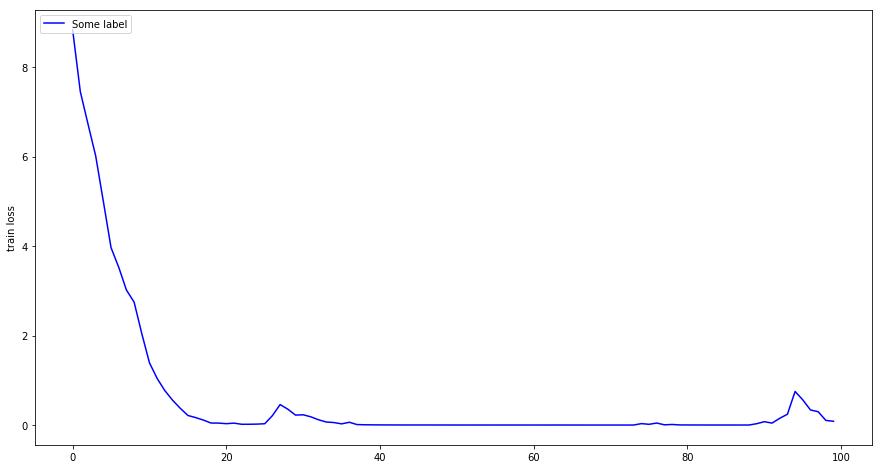

Exact Match


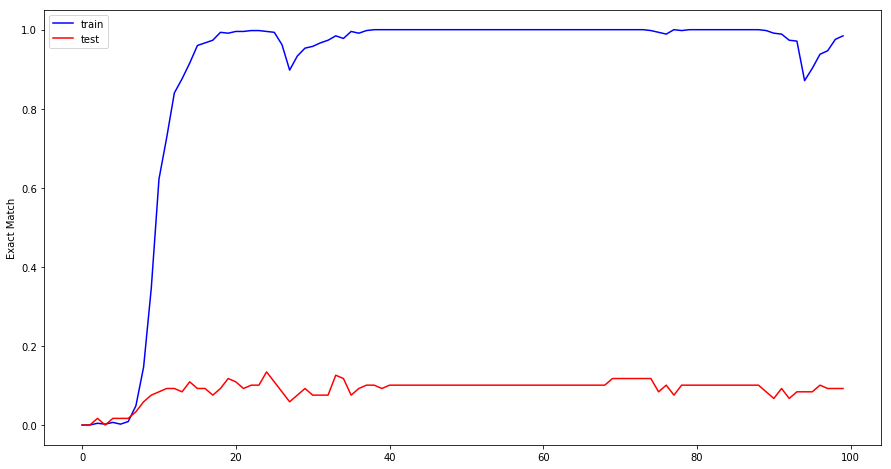

F-Measure


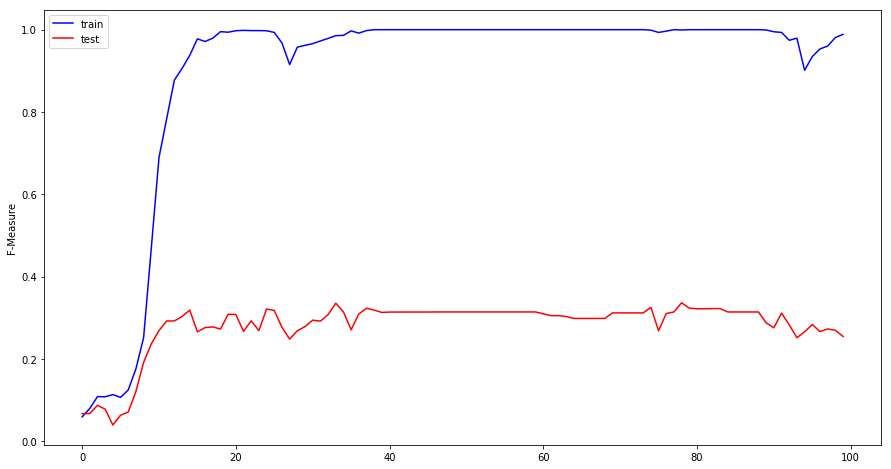

In [24]:
# Visualizations
print("Training Loss")
visualize_loss(loss=op[0], _name="train loss", _only_epoch=True)

# if len(op[1]) > 0:

print("Exact Match")
visualize_loss(loss=op[1], loss2=op[4], _label="train", _label2="test", _name="Exact Match", _only_epoch=True)
# visualize_loss(loss=op[1], _label="train em", _label2="test em", _only_epoch=True)

print("F-Measure")
visualize_loss(loss=op[2], loss2=op[5], _label="train", _label2="test", _name="F-Measure")

# op[3]
# print(op[1])


In [30]:
pickle.dump(op, open('./performance/domain-glove-17-07-2018/op.dump', 'wb+'))

In [18]:
# # Testing (temp)
# models = { 'ques_model': ques_model,
#            'para_model': para_model,
#            'mlstm_model':  mlstm_model,
#            'pointer_decoder_model': pointer_decoder_model
#          }
# save_model(loc=macros['save_model_loc'], models=models, epochs=0)

In [19]:
# # Try loading the model
# ques_model = torch.load(os.path.join(macros['save_model_loc'], 'ques_model.torch'))
# print("Ques Model\n", ques_model)

# para_model = torch.load(os.path.join(macros['save_model_loc'], 'para_model.torch'))
# print("Para Model\n", para_model)

# mlstm_model = torch.load(os.path.join(macros['save_model_loc'], 'mlstm_model.torch'))
# print("MLSTM Model\n", mlstm_model)

# pointer_decoder_model = torch.load(os.path.join(macros['save_model_loc'], 'pointer_decoder_model.torch'))
# print("Pointer Decoder model\n", pointer_decoder_model)

# Create dummy data for testing the predict fn
q = np.random.randint(0, len(vectors), (1, 30))
p = np.random.randint(0, len(vectors), (1, 200))
qa = np.repeat(q,macros['batch_size'],axis=0)
pa = np.repeat(p,macros['batch_size'],axis=0)

qb = np.repeat(q,10,axis=0)
pb = np.repeat(p,10,axis=0)

# print(p_repeat.shape)
# print(q_repeat.shape)

ysa, yea, _ = predict(torch.tensor(pa, dtype=torch.long, device=device), 
                                   torch.tensor(qa, dtype=torch.long, device=device),
                                   ques_model=ques_model.eval(),
                                   para_model=para_model.eval(),
                                   mlstm_model=mlstm_model.eval(),
                                   pointer_decoder_model=pointer_decoder_model.eval(),
                                    macros=macros,
                                    debug=macros['debug'])

ysb, yeb, _ = predict(torch.tensor(pb, dtype=torch.long, device=device), 
                                   torch.tensor(qb, dtype=torch.long, device=device),
                                   ques_model=ques_model.eval(),
                                   para_model=para_model.eval(),
                                   mlstm_model=mlstm_model.eval(),
                                   pointer_decoder_model=pointer_decoder_model.eval(),
                                    macros=macros,
                                    debug=macros['debug'])

print(torch.argmax(ysa.squeeze(), dim=1))
print(torch.argmax(ysb.squeeze(), dim=1))

tensor([ 150,  150,  150,  150,  150,  150,  150,  150,  150,  150,
         150,  150,  150,  150,  150,  150,  150,  150,  150,  150,
         150,  150,  150,  150,  150,  150,  150,  150,  150,  150,
         150,  150,  150,  150,  150,  150,  150,  150,  150,  150,
         150,  150,  150,  150,  150,  150,  150,  150,  150,  150], device='cuda:0')
tensor([ 150,  150,  150,  150,  150,  150,  150,  150,  150,  150], device='cuda:0')


In [20]:
torch.argmax(y_cap_start.squeeze(), dim=1)

NameError: name 'y_cap_start' is not defined